# A* Algorithm Implementation in Python

Most codes from http://asl.stanford.edu/aa274/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Represents a motion planning problem to be solved using A*
class AStar(object):

    def __init__(self, statespace_lo, statespace_hi, x_init, x_goal, occupancy, resolution=1):
        self.statespace_lo = statespace_lo         # state space lower bound (e.g., (-5, -5))
        self.statespace_hi = statespace_hi         # state space upper bound (e.g., (5, 5))
        self.occupancy = occupancy                 # occupancy grid
        self.resolution = resolution               # resolution of the discretization of state space (cell/m)
        self.x_init = self.snap_to_grid(x_init)    # initial state
        self.x_goal = self.snap_to_grid(x_goal)    # goal state

        self.closed_set = []    # the set containing the states that have been visited
        self.open_set = []      # the set containing the states that are condidate for future expension

        self.f_score = {}       # dictionary of the f score (estimated cost from start to goal passing through state)
        self.g_score = {}       # dictionary of the g score (cost-to-go from start to state)
        self.came_from = {}     # dictionary keeping track of each state's parent to reconstruct the path

        self.open_set.append(x_init)
        self.g_score[x_init] = 0
        self.f_score[x_init] = self.distance(x_init,x_goal)

        self.path = None        # the final path as a list of states

    # Checks if a give state is free, meaning it is inside the bounds of the map and
    # is not inside any obstacle
    # INPUT: (x)
    #          x - tuple state
    # OUTPUT: Boolean True/False
    def is_free(self, x):
        if x==self.x_init or x==self.x_goal:
            return True
        for dim in range(len(x)):
            if x[dim] < self.statespace_lo[dim]:
                return False
            if x[dim] >= self.statespace_hi[dim]:
                return False
        if not self.occupancy.is_free(x):
            return False
        return True

    # computes the euclidean distance between two states
    # INPUT: (x1, x2)
    #          x1 - first state tuple
    #          x2 - second state tuple
    # OUTPUT: Float euclidean distance
    def distance(self, x1, x2):
        return np.linalg.norm(np.array(x1)-np.array(x2))

    # returns the closest point on a discrete state grid
    # INPUT: (x)
    #          x - tuple state
    # OUTPUT: A tuple that represents the closest point to x on the discrete state grid
    def snap_to_grid(self, x):
        return (self.resolution*round(x[0]/self.resolution), self.resolution*round(x[1]/self.resolution))

    # gets the FREE neighbor states of a given state. Assumes a motion model
    # where we can move up, down, left, right, or along the diagonals by an
    # amount equal to self.resolution.
    # Use self.is_free in order to check if any given state is indeed free.
    # Use self.snap_to_grid (see above) to ensure that the neighbors you compute
    # are actually on the discrete grid, i.e., if you were to compute neighbors by
    # simply adding/subtracting self.resolution from x, numerical error could
    # creep in over the course of many additions and cause grid point equality
    # checks to fail. To remedy this, you should make sure that every neighbor is
    # snapped to the grid as it is computed.
    # INPUT: (x)
    #           x - tuple state
    # OUTPUT: List of neighbors that are free, as a list of TUPLES
    def get_neighbors(self, x):
        neighs = []
        for dx1 in [-self.resolution, 0, self.resolution]:
            for dx2 in [-self.resolution, 0, self.resolution]:
                if dx1==0 and dx2==0:
                    # don't include itself
                    continue
                new_x = (x[0]+dx1,x[1]+dx2)
                if self.is_free(new_x):
                    neighs.append(self.snap_to_grid(new_x))
        return neighs

    # Gets the state in open_set that has the lowest f_score
    # INPUT: None
    # OUTPUT: A tuple, the state found in open_set that has the lowest f_score
    def find_best_f_score(self):
        return min(self.open_set, key=lambda x: self.f_score[x])

    # Use the came_from map to reconstruct a path from the initial location
    # to the goal location
    # INPUT: None
    # OUTPUT: A list of tuples, which is a list of the states that go from start to goal
    def reconstruct_path(self):
        path = [self.x_goal]
        current = path[-1]
        while current != self.x_init:
            path.append(self.came_from[current])
            current = path[-1]
        return list(reversed(path))

    # Plots the path found in self.path and the obstacles
    # INPUT: None
    # OUTPUT: None
    def plot_path(self):
        if not self.path:
            return

        fig = plt.figure()

        self.occupancy.plot(fig.number)

        solution_path = np.array(self.path) * self.resolution
        plt.plot(solution_path[:,0],solution_path[:,1], color="green", linewidth=2, label="solution path", zorder=10)
        plt.scatter([self.x_init[0]*self.resolution, self.x_goal[0]*self.resolution], 
                    [self.x_init[1]*self.resolution, self.x_goal[1]*self.resolution], color="green", s=30, zorder=10)
        plt.annotate(r"$x_{init}$", np.array(self.x_init)*self.resolution + np.array([.2, 0]), fontsize=16)
        plt.annotate(r"$x_{goal}$", np.array(self.x_goal)*self.resolution + np.array([.2, 0]), fontsize=16)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.03), fancybox=True, ncol=3)

        plt.axis('equal')
        plt.show()

    # Solves the planning problem using the A* search algorithm. It places
    # the solution as a list of of tuples (each representing a state) that go
    # from self.x_init to self.x_goal inside the variable self.path
    # INPUT: None
    # OUTPUT: Boolean, True if a solution from x_init to x_goal was found
    def solve(self):
        while len(self.open_set)>0:
            current = self.find_best_f_score()
            if current == self.x_goal:
                self.path = self.reconstruct_path()
                return True
            self.open_set.remove(current)
            self.closed_set.append(current)
            for n in self.get_neighbors(current):
                if n in self.closed_set:
                    continue
                tentative_gscore = self.g_score[current] + self.distance(current,n)
                if n not in self.open_set:
                    self.open_set.append(n)
                elif tentative_gscore >= self.g_score[n]:
                    continue
                self.came_from[n] = current
                self.g_score[n] = tentative_gscore
                self.f_score[n] = self.g_score[n] + self.distance(n,self.x_goal)

        return False

In [2]:
# A 2D state space grid with a set of rectangular obstacles. The grid is fully deterministic
class DetOccupancyGrid2D(object):
    def __init__(self, width, height, obstacles):
        self.width = width
        self.height = height
        self.obstacles = obstacles

    def is_free(self, x):
        for obs in self.obstacles:
            inside = True
            for dim in range(len(x)):
                if x[dim] < obs[0][dim] or x[dim] > obs[1][dim]:
                    inside = False
                    break
            if inside:
                return False
        return True

    def plot(self, fig_num=0):
        fig = plt.figure(fig_num)
        for obs in self.obstacles:
            ax = fig.add_subplot(111, aspect='equal')
            ax.add_patch(
            patches.Rectangle(
            obs[0],
            obs[1][0]-obs[0][0],
            obs[1][1]-obs[0][1],))

[((6, 6), (8, 7)), ((2, 1), (4, 2)), ((2, 4), (4, 6)), ((6, 2), (8, 4))]


/Users/mottaghi/PycharmProjects/AI4ALL_robatics/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


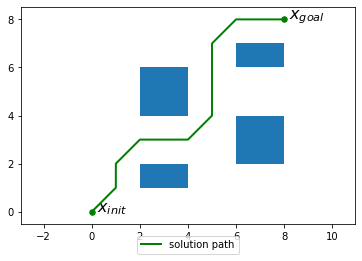

In [3]:
### TESTING

# A simple example
width = 10
height = 10
x_init = (0,0)
x_goal = (8,8)
obstacles = [((6,6),(8,7)),((2,1),(4,2)),((2,4),(4,6)),((6,2),(8,4))]
print(obstacles)
occupancy = DetOccupancyGrid2D(width, height, obstacles)

astar = AStar((0, 0), (width, height), x_init, x_goal, occupancy)

if not astar.solve():
    print("No path found")
    exit(0)

astar.plot_path()

/Users/mottaghi/PycharmProjects/AI4ALL_robatics/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


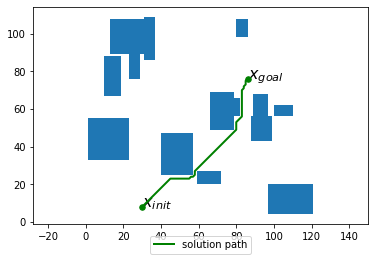

In [4]:
# A large random example
width = 101
height = 101
num_obs = 15
min_size = 5
max_size = 25
obs_corners_x = np.random.randint(0,width,num_obs)
obs_corners_y = np.random.randint(0,height,num_obs)
obs_lower_corners = np.vstack([obs_corners_x,obs_corners_y]).T
obs_sizes = np.random.randint(min_size,max_size,(num_obs,2))
obs_upper_corners = obs_lower_corners + obs_sizes
obstacles = list(zip(obs_lower_corners,obs_upper_corners))
occupancy = DetOccupancyGrid2D(width, height, obstacles)
x_init = tuple(np.random.randint(0,width-2,2).tolist())
x_goal = tuple(np.random.randint(0,height-2,2).tolist())
while not (occupancy.is_free(x_init) and occupancy.is_free(x_goal)):
    x_init = tuple(np.random.randint(0,width-2,2).tolist())
    x_goal = tuple(np.random.randint(0,height-2,2).tolist())

astar = AStar((0, 0), (width, height), x_init, x_goal, occupancy)

if not astar.solve():
    print("No path found")
    exit(0)

astar.plot_path()